# QRS Complex Dectition Algorithm


## Acquiring the Data

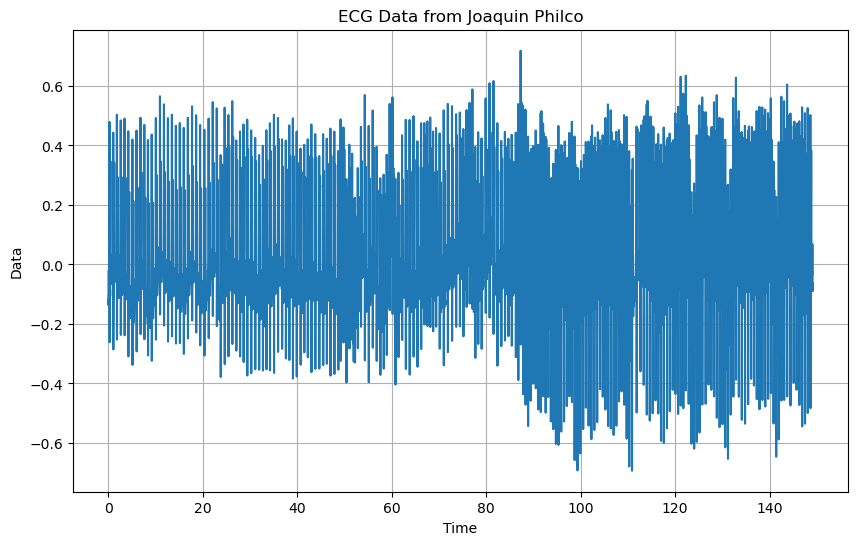

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset with comma as delimiter
df = pd.read_csv("lab5_Philco-L05.txt", delimiter=",")

# Get the time column
time = df.iloc[:, 0]

# Get the Channel data
data = df.iloc[:, 1]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time, data)
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('ECG Data from Joaquin Philco')
plt.grid(True)
plt.show()


## Removing the DC Component

In [138]:
from scipy.signal import argrelextrema
df_subset = data[:3000]
time_subset = time[:3000]

# remove dc component
df_subset = df_subset - np.sum(df_subset)/len(df_subset)


## Labeling Data for Training

In [ ]:

q_indices = [219, 1018, 1785, 2605]
r_indices = [257, 1052, 1825, 2641]
s_indices = [284, 1079, 1851, 2663]

# Plot the ECG signal
plt.figure(figsize=(10, 6))
plt.plot(time_subset, df_subset, label='ECG Data')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('ECG Data from Joaquin Philco')
plt.grid(True)

# Marking Q Features
plt.scatter(time_subset[q_indices], df_subset[q_indices], color='purple', marker='x', label='Q')

# Marking R Features
plt.scatter(time_subset[r_indices], df_subset[r_indices], color='green', marker='x', label='R')

# Marking S Features
plt.scatter(time_subset[s_indices], df_subset[s_indices], color='red', marker='x', label='S')

plt.xlabel('Time')
plt.ylabel('Data')
plt.title('ECG Data with QRS Features')
plt.legend()
plt.grid(True)
plt.show()

## Find the Absolute Second Derivative

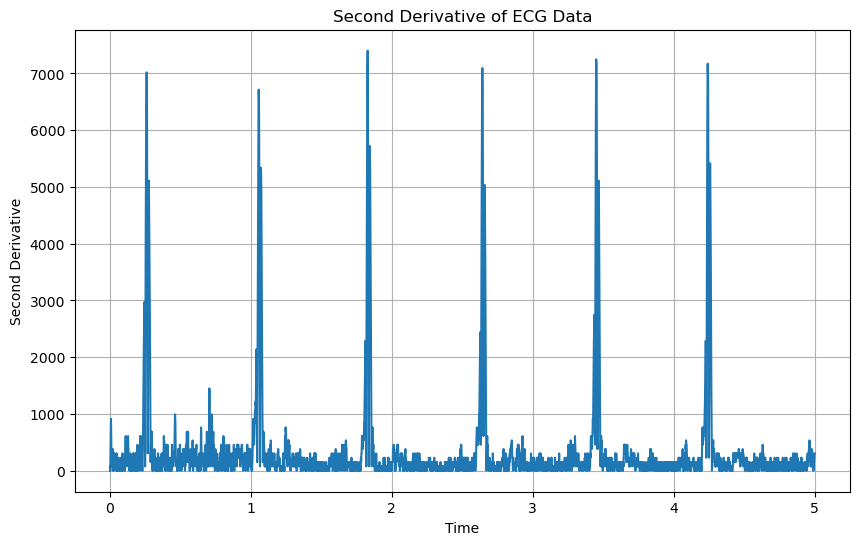

In [80]:
# Compute the first derivative
first_derivative = np.gradient(df_subset, time_subset)

# Compute the second derivative
second_derivative = abs(np.gradient(first_derivative, time_subset))


# Plot the second derivative
plt.figure(figsize=(10, 6))
plt.plot(time_subset, second_derivative)
plt.xlabel('Time')
plt.ylabel('Second Derivative')
plt.title('Second Derivative of ECG Data')
plt.grid(True)
plt.show()

## Apply a Filter a Low Pass Filter

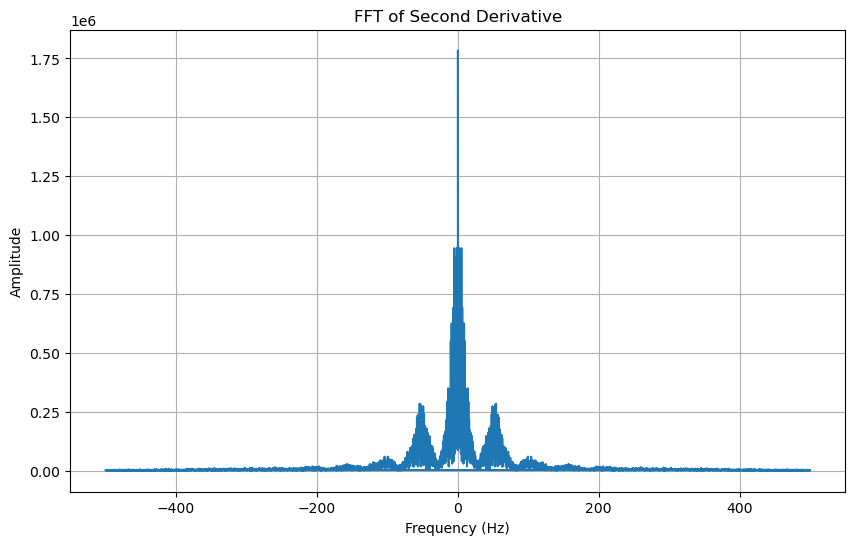

In [81]:
# Apply FFT to the second derivative
fft_result = np.fft.fft(second_derivative)

# Compute the frequencies corresponding to the FFT result
n = len(second_derivative)
freq = np.fft.fftfreq(n, d=(time_subset[1] - time_subset[0]))

# Plot the FFT result
plt.figure(figsize=(10, 6))
plt.plot(freq, np.abs(fft_result))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of Second Derivative')
plt.grid(True)
plt.show()

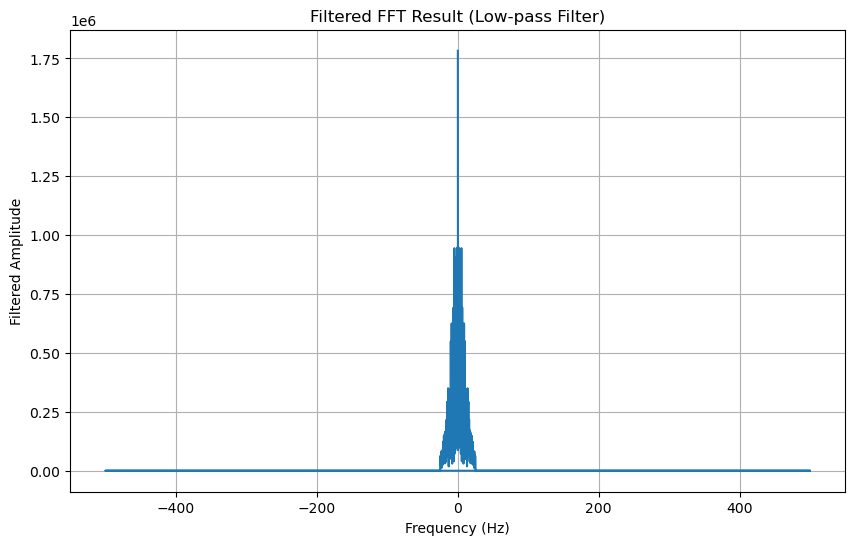

In [88]:
# Define the cutoff frequency for the low-pass filter
cutoff_freq = 25  # Adjust this value according to your requirements

# Create the low-pass filter
lowpass_filter = np.zeros_like(freq)
lowpass_filter[np.abs(freq) <= cutoff_freq] = 1

# Apply the low-pass filter to the FFT result
filtered_fft_result = fft_result * lowpass_filter

# Plot the filtered FFT result
plt.figure(figsize=(10, 6))
plt.plot(freq, np.abs(filtered_fft_result))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filtered Amplitude')
plt.title('Filtered FFT Result (Low-pass Filter)')
plt.grid(True)
plt.show()

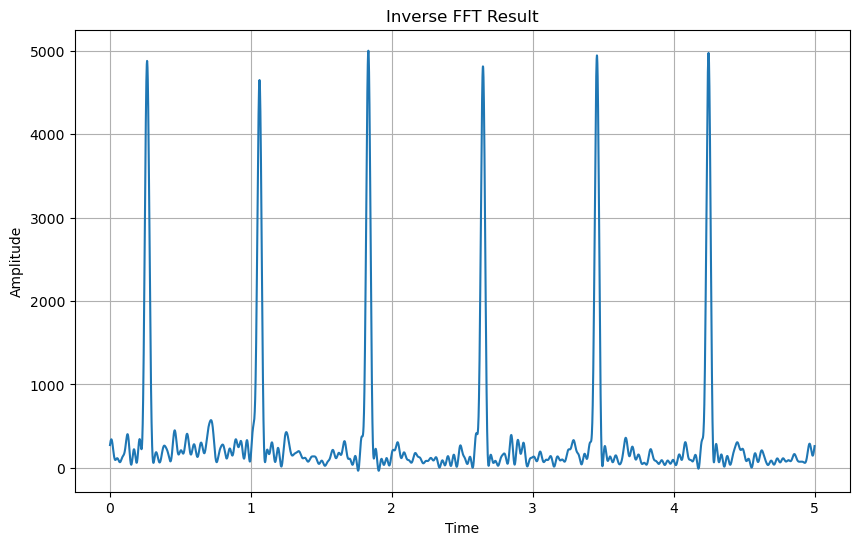

In [89]:
# Compute the inverse FFT
ifft_result = np.fft.ifft(filtered_fft_result)

# Plot the inverse FFT result
plt.figure(figsize=(10, 6))
plt.plot(time_subset, np.real(ifft_result))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Inverse FFT Result')
plt.grid(True)
plt.show()